## This script contains the following:

### 1. Importing libraries and data
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing the Federal Reserve Economic Data
### 6. Results

### 1. Importing libraries and data

In [608]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [609]:
# Configure API key 

quandl.ApiConfig.api_key = 'gw4yoy7-2XEz_tsYj93n'

In [610]:
# Importing the Energy Production and Consumption: 'Geothermal Power Capacity - Total Asia' variable.

data = quandl.get('BP/GEO_CAP_TASP')

In [611]:
data.head()

,Value
Date,
1990-12-31,1393.4
1995-12-31,1859.5
2000-12-31,3344.7
2001-12-31,3603.7
2002-12-31,3559.7


In [612]:
data.shape

(23, 1)

In [613]:
data.columns

Index(['Value'], dtype='object')

In [614]:
type(data)

pandas.core.frame.DataFrame

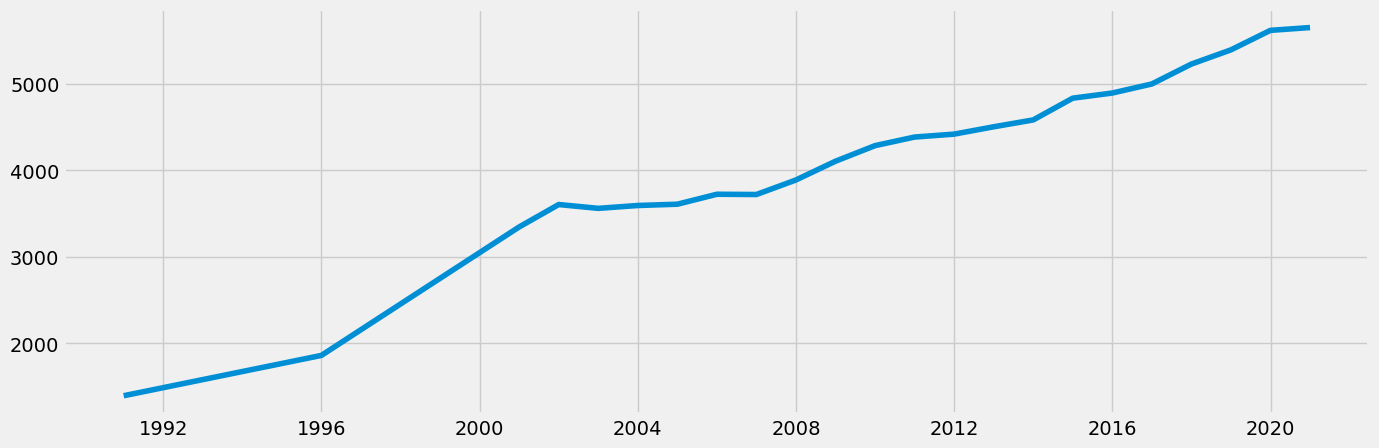

In [615]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [616]:
# Reset index so that we can use the "Date" column as a filter

data_2 = data.reset_index()

In [617]:
data_2.head()

,Date,Value
0,1990-12-31,1393.4
1,1995-12-31,1859.5
2,2000-12-31,3344.7
3,2001-12-31,3603.7
4,2002-12-31,3559.7


In [618]:
# Create a new data_sub subset using the loc function and the “Date” column for year 1996 to 2020

data_sub = data_2.loc[(data_2['Date'] >= '1996-01-01') & (data_2['Date'] <= '2020-12-31')]

#### I have chosen to use data from year 1996 as it is when the line chart starts to increase significantly 

In [619]:
data_sub.shape

(21, 2)

In [638]:
data_sub.head()

,Value
datetime,
2000-12-31,3344.7
2001-12-31,3603.7
2002-12-31,3559.7
2003-12-31,3592.6
2004-12-31,3607.6


In [621]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date."
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2000-12-31,3344.7
2001-12-31,3603.7
2002-12-31,3559.7
2003-12-31,3592.6
2004-12-31,3607.6


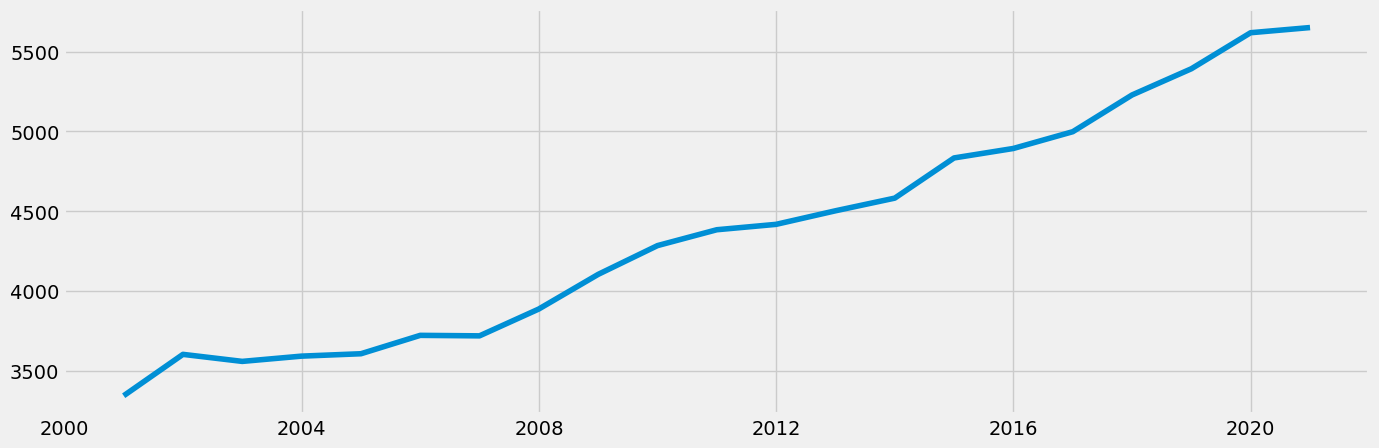

In [622]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [623]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [624]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [625]:
# Decompose the time series using an additive model (here, the period is set to 4, for quaterly, since there are 4 quarters in a year).

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period=4)

In [626]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

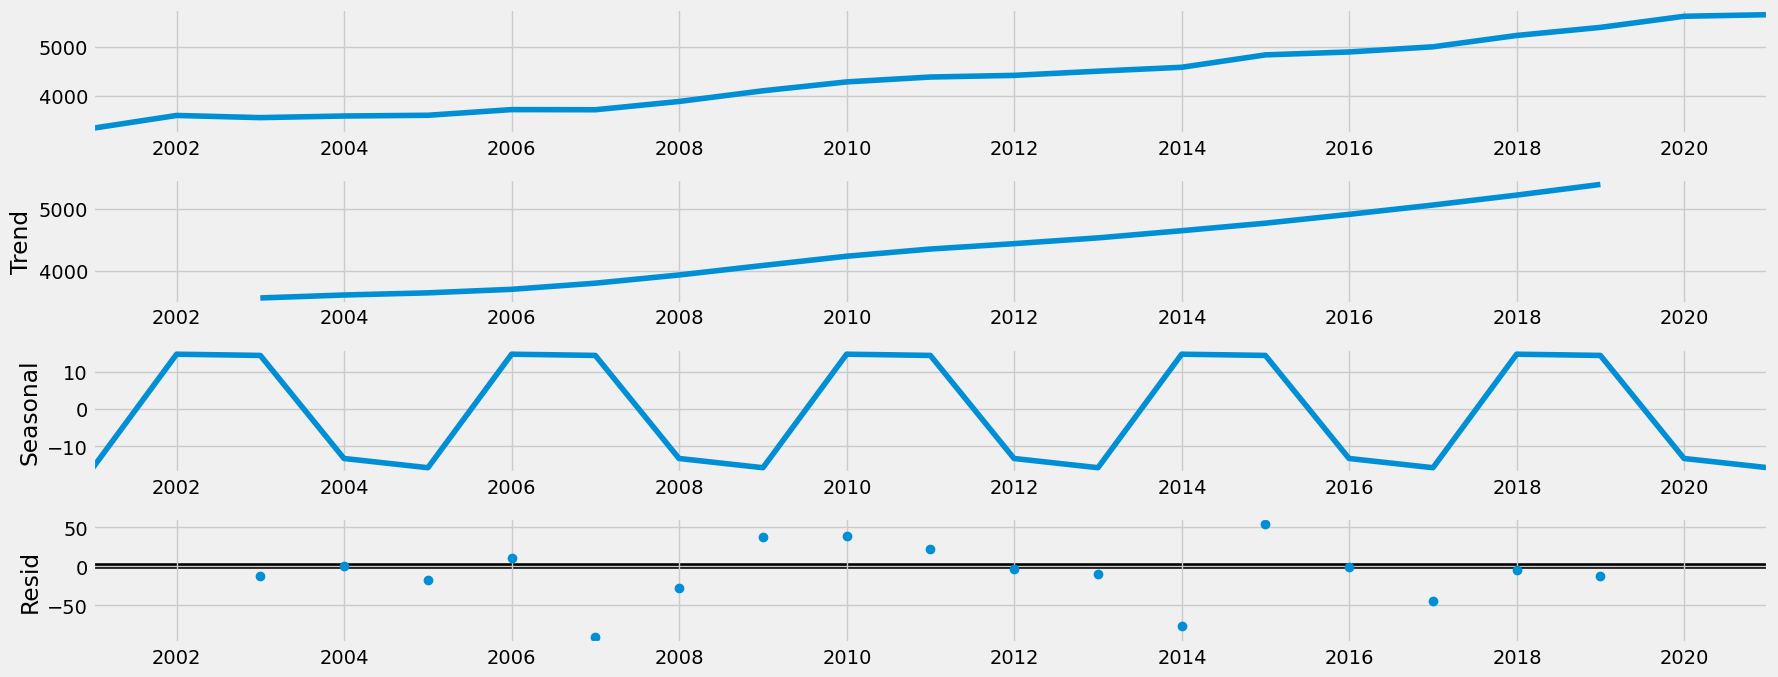

In [627]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Observation:

- First component is called the level, it is the data itself including all of its components.
- Second component is the underlying trend: here we don't have much noises, the level and trend appear the same.
- Third component is the seasonality: here we can see the seasonal fluctuations that changes at a regular interval.
- Fourth component is the noise called here 'residual': here we can see that there isn’t much unexplained noise.

Overall, we can see that the time series has an overall increasing trend, with some seasonality that appears to repeat every four years. The residual component shows some noise and irregularity around the trend and seasonal components. Therefore, the decomposition suggests that the time series might be useful to model with a combination of trend and seasonal components.

### 4. Testing for stationarity

In [639]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series

dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  2.514805
p-value                         0.999054
Number of Lags Used             8.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


#### Observation:

- When the test statistic is larger than critical value(s) = We can’t reject null hypothesis
- When the test statistic is smaller than critical value(s) = We can reject null hypothesis

Here:

- The test statistic is 2.514805 and the p-value is 0.999054.
- The critical values at 1%, 5%, and 10% significance levels are -4.137829, -3.154972, and -2.714477, respectively.

Since the test statistic is greater than all the critical values, we cannot reject the null hypothesis and conclude that the time series is non-stationary.

Note : It’s always important to run proper tests to back up the assumptions with statistical results.

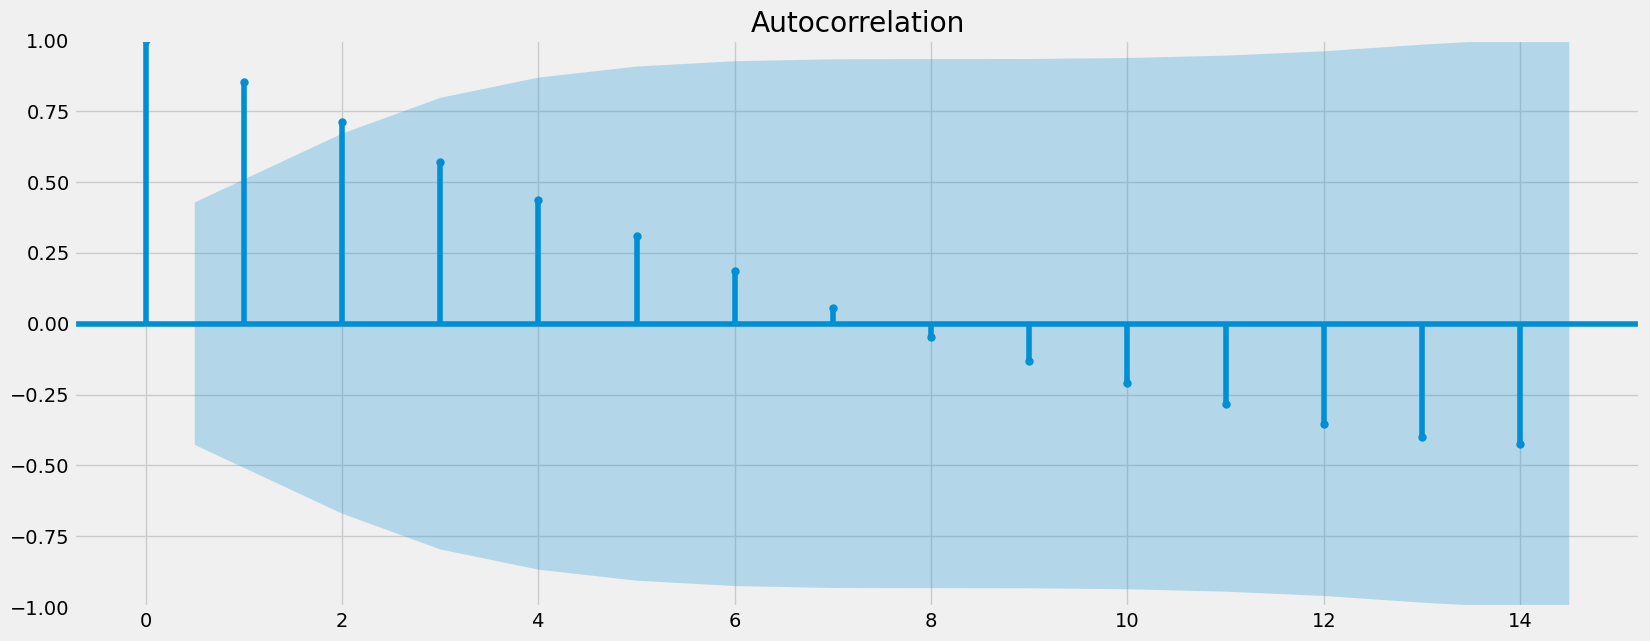

In [640]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

#### Note:

- The vertical lines represent the lags in the series.
- The blue area represents the confidence interval.

- When lines go above the blue edge of the confidence interval, this means we have lags that are significantly correlated with each other.
- And when we have many lags beyond this interval, we can deduce that the data is non-stationary.

### 5. Stationarizing the Federal Reserve Economic Data

In [641]:
# Differencing technique.

data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [647]:
data_diff.dropna(inplace = True) # Here, we remove the missing values that came about as a result of the differencing. 
# We need to remove these or we won't be able to run the Dickey-Fuller test.

In [648]:
data_diff.head()

,Value
datetime,
2001-12-31,259.0
2002-12-31,-44.0
2003-12-31,32.9
2004-12-31,15.0
2005-12-31,115.1


In [649]:
data_diff.columns

Index(['Value'], dtype='object')

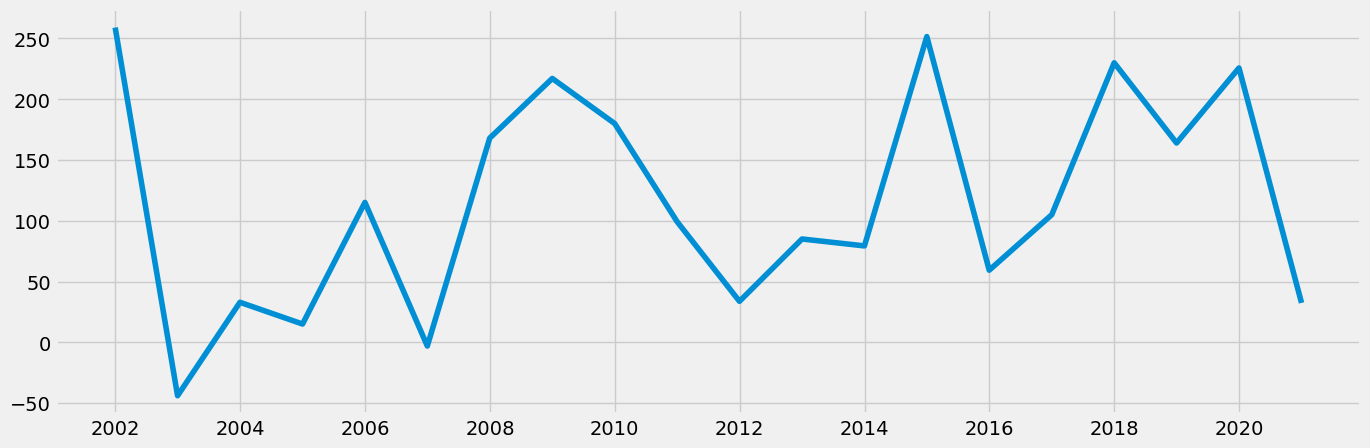

In [650]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [651]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.409676
p-value                         0.000285
Number of Lags Used             0.000000
Number of Observations Used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64


#### Rule of thumb:

- You need at least ten significant lags (or ten vertical lines above the confidence interval) for a second round of differencing to be necessary.
- p-value should be (p<0.05).

### 6. Results

- The test statistic value is -4.41, which is smaller than the critical values at 1%, 5%, and 10% significance levels. This suggests that we can reject the null hypothesis that the data is non-stationary.

- The p-value of the test is 0.0003, which is smaller than the significance level of 0.05. This also suggests that we can reject the null hypothesis.

- The number of lags used in the test is 0, which means that the test automatically determined the optimal number of lags to use.

- The number of observations used in the test is 19, the total number of observations in the dataset was 23.

- The critical values at 1%, 5%, and 10% significance levels are -3.83, -3.03, and -2.66, respectively.

Based on these results, we can conclude that the data is stationary. This is a desirable property for time series analysis as it allows us to use various statistical methods that require stationary data.